In [1]:
# Required imports for the report.
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import urllib.request
from PIL import Image
from pydataset import data
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
from wrangle2 import *
from explore2 import *
from modeling2 import *
import env
import os
pd.options.mode.chained_assignment = None

# Zillow Pricing Estimates - A Project on Linear Regression

#### The purpose of this project was to use linear regression techniques to desgin a model that could estimate the pricing of Single Family Properties based on the tax value. The dataset was acquired from a Zillow database and used data from 2017. Homes that were considered equivalent to single family properties were included.

## Project Goals:

#### - Create a model that can predict the tax evaluation with greater accuracy than baseline.

#### - Avoid unrelated correlations and find useful drivers for the model, and then make recommendations to improve the model.

## Wrangling the Data

In [2]:
train, validate, test = wrangle_zillow()

Number of observations removed: 8161


In [3]:
display(train.head(3).T)
display(train.fips.unique())
nums, cats = dtypes_to_list(train)
print(nums)
print(cats)

,35903,32641,41241
parcelid,11291200,13968269,12783351
bedroomcnt,3.0,4.0,3.0
bathroomcnt,2.0,2.5,2.0
cal_fin_sqf,1170.0,2579.0,1726.0
tax_val,124263.0,99083.0,62913.0
year_built,1956,1969,1919
taxamount,2250.2,1585.88,1201.62
fips,f6037,f6059,f6037
f6037,1,0,1
f6059,0,1,0


array(['f6037', 'f6059', 'f6111'], dtype=object)

['parcelid', 'bedroomcnt', 'bathroomcnt', 'cal_fin_sqf', 'tax_val', 'year_built', 'taxamount']
['fips', 'f6037', 'f6059', 'f6111']


## How did we wrangle the data? Some takeaways...

#### The data was acquired from the server and saved into a .csv file for later use incase of connection loss. Then the outliers of the top percentile of properties were removed to avoid them skewing the data due to their value being way too high. These tax values would not be useful for our model. Errors in the data were cleaned such as missing values, improperly classified homes, and dates that were outside of 2017.

#### The dataframe shows 3 FIPS codes, this means that the data is specific to these 3 counties only and is not countrywide or even statewide.

## Exploring the Data

#### Since property value is relative to surrounding homes and their selling price, the variance between the 3 regions should be checked.

In [4]:
f6059 = train[train.fips == "f6059"]
f6037 = train[train.fips == "f6037"]
f6111 = train[train.fips == "f6111"]

α = .05
f, p = stats.f_oneway(f6059.tax_val, f6037.tax_val, f6111.tax_val)
print(p > α)

False


#### Since the p-value for the variance test between samples was less than α, we must conclude that the location of the properties according to the FIPS code is significant and should be included in the model. This makes sense as one or more counties may be exclusively higher value properties.

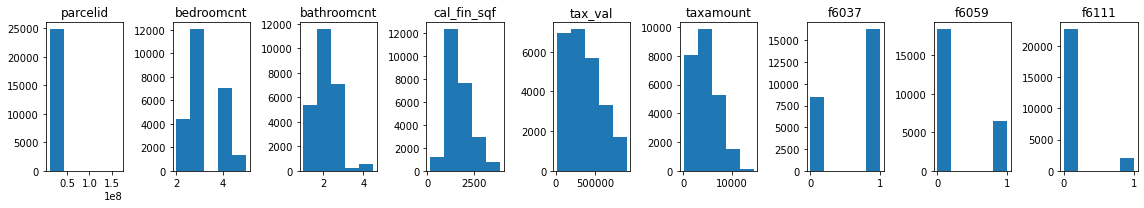

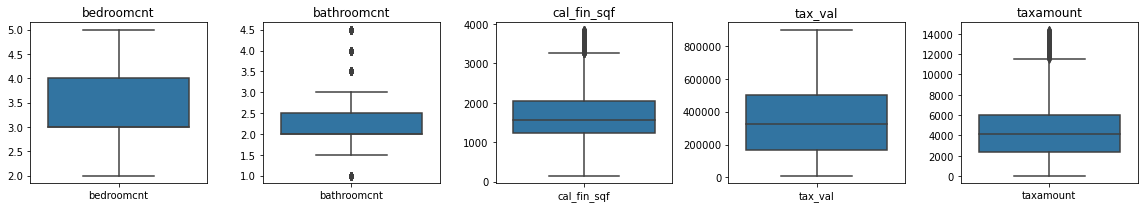

In [5]:
# Continuing the data exploration...
get_box_hist_viz(train)

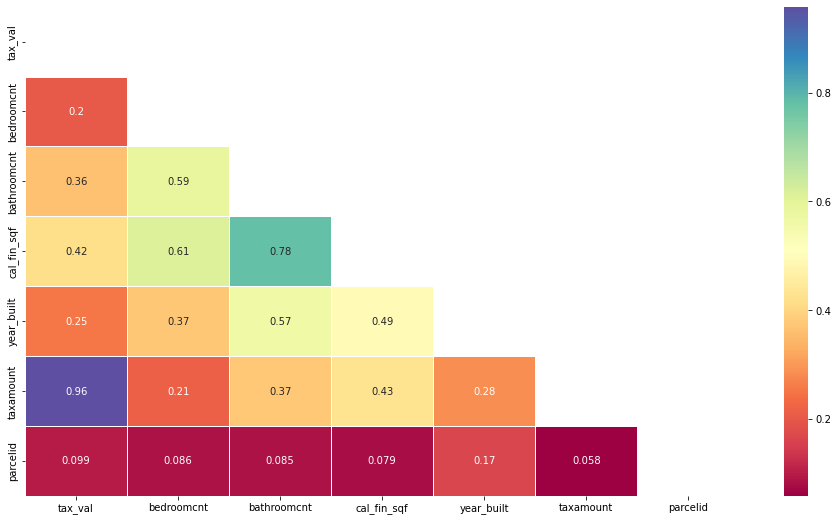

In [6]:
# Reordering the list of features to have them more easily comparable to the target.
corr_features = nums
neworder = [4, 1, 2, 3, 5, 6, 0]
corr_features = [corr_features[i] for i in neworder]
correlation_viz(train, corr_features)

#### It is important to remember that bedrooms and bathrooms would have their own square footage, but this would be included in the final calculated total of square footage. This logically should rule them out as a distracting correlation. They will not be included in the model.

#### Likewise, we can exclude taxamount from our model as its correlation with tax value will be misleading.

#### We can double-check this with some further statistical analysis.

In [7]:
X_train, y_train = target_split(train, "tax_val")

In [8]:
corr_features = corr_features[1:]
kbest_feats = select_kbest(X_train[corr_features], y_train.values.ravel(), k=4)
print(kbest_feats, "\n")
rfe_feats = rfe(X_train[corr_features], y_train.values.ravel(), k=4)
print(rfe_feats)

Index(['bathroomcnt', 'cal_fin_sqf', 'year_built', 'taxamount'], dtype='object') 

Index(['bedroomcnt', 'bathroomcnt', 'year_built', 'taxamount'], dtype='object')


## Are we ready to model? Some exploartion takeaways...

#### As previously discussed, property value is about location, location, location. Also, even though the SelectKBest and RFE feature selections showed varying results, if run multiple times, it is easy to see how bedrooms, bathrooms, and taxamount confused the selection. This helped to prove earlier suspicions. You can see this happen if you refresh the project and run the cells again, you will get different features. Make sure not to run the cells on the same instance, or you will get an error.

## Creating the Models

In [9]:
#initializing model functions and preparing data splits for modeling.
OLS = lm.LinearRegression()
LassoLars = lm.LassoLars(normalize = True)
GLM = lm.TweedieRegressor(power = 1, alpha = 0)

model_features = ['cal_fin_sqf', 'year_built', "f6037", "f6059", "f6111", "tax_val"]

X_train, y_train = target_split(train[model_features], "tax_val")
X_validate, y_validate = target_split(validate[model_features], "tax_val")
X_test, y_test = target_split(test[model_features], "tax_val")

In [10]:
# Establishing model baseline.
baseline = baseline_mean(y_validate, "tax_val")
baseline

352071.24957651045

### Scaling

In [11]:
model_features = model_features[:-1]
scaled_X_train, scaled_X_validate, scaled_X_test = scaling_min_max(X_train, X_validate, X_test, model_features)
scaled_X_train.head()

,cal_fin_sqf,year_built,f6037,f6059,f6111
35903,0.274764,0.565217,1.0,0.0,0.0
32641,0.655061,0.659420,0.0,1.0,0.0
41241,0.424831,0.297101,1.0,0.0,0.0
2384,0.273684,0.123188,1.0,0.0,0.0
6064,0.223482,0.579710,1.0,0.0,0.0


### OLS Model

In [12]:
OLS.fit(scaled_X_train, y_train)
yhat_train = OLS.predict(scaled_X_train)
yhat = OLS.predict(scaled_X_validate)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

195242.06
195182.57
0.19


### LassoLars

In [13]:
LassoLars.fit(scaled_X_train, y_train)
yhat_train = LassoLars.predict(scaled_X_train)
yhat = LassoLars.predict(scaled_X_validate)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

195240.73
195184.92
0.19


### GLM

In [14]:
GLM.fit(scaled_X_train, y_train)
yhat_train = GLM.predict(scaled_X_train)
yhat = GLM.predict(scaled_X_validate)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

195075.16
195104.39
0.191


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Which was the best model? Some takeaways...

#### Modeling showed that the difference between them to make predictions was way too similar. This might mean that this type of modeling is not optimal for this type of problem. 

#### However, to complete the project, one model must be chosen for testing. I chose OLS because it was the first option of these models with hardly any  difference. I have a hunch it doesn't matter in the end. Further feature engineering or modeling may prove that hypothesis wrong.

## Testing - Finally Here!

In [17]:
OLS.fit(scaled_X_train, y_train)
yhat_train = OLS.predict(scaled_X_train)
yhat = OLS.predict(scaled_X_test)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_test = mean_squared_error(y_test, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_test), 2))
print(round((r2_score(y_test, yhat)), 3), "\n")

y_train["baseline_mean"] = baseline
y_test["baseline_mean"] = baseline

rmse_train = mean_squared_error(y_train["tax_val"], y_train.baseline_mean)**(0.5)
rmse_test = mean_squared_error(y_test["tax_val"], y_test.baseline_mean)**(0.5)
print(rmse_train)
print(rmse_test)
print(r2_score(y_test, yhat))

138057.02
139128.18
0.436 

217810.2919854756
218206.34640233064
0.4362519192996382


## Couldn't beat baseline! Modeling takeaways...

#### It seems these models may require more features put into them to improve their predictive powers. But with the gains being so marginal, it seems like this lends creedence to the earlier hunch that this might need a different approach.

## Next Steps

#### Creating new features and implementing as many features into the models as possible may help, but the true next step would be to use a different method.

## Want to recreate this project?

#### - Download the wrangle2.py, explore2.py, modeling2.py, and final_report2.ipynb files.
#### - Add your own env.py file to the directory (username, hostname, password).
#### - Run the final_report2.ipynb notebook.